In [1]:
import numpy as np
from jax import jit
from jax import numpy as jnp
from matplotlib import pyplot as plt

from jwave import FourierSeries
from jwave.acoustics import acoustic_solver
from jwave.geometry import *
from jwave.geometry import Sensors, circ_mask, points_on_circle
from jwave.utils import show_field
from jwave.ode import TimeAxis
from jwave.ode import SemiImplicitEulerCorrected
from diffrax import RecursiveCheckpointAdjoint, BacksolveAdjoint, DirectAdjoint

domain = Domain((256, 256), (0.1e-3, 0.1e-3))
medium = Medium(domain=domain, sound_speed=1500.0)
time_axis = TimeAxis.from_cfl_number(medium, cfl=0.3)

/home/antonio/anaconda3/envs/jwave/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
# Defining the initial pressure

N = domain.N
mask1 = circ_mask(N, 16, (100, 100))
mask2 = circ_mask(N, 10, (160, 120))
mask3 = circ_mask(N, 20, (128, 128))
mask4 = circ_mask(N, 60, (128, 128))
p0 = 5.0 * mask1 + 3.0 * mask2 + 4.0 * mask3 + 0.5 * mask4

p0 = 1.0 * jnp.expand_dims(p0, -1)
p0 = FourierSeries(p0, domain)

Text(0.5, 1.0, 'Initial pressure')

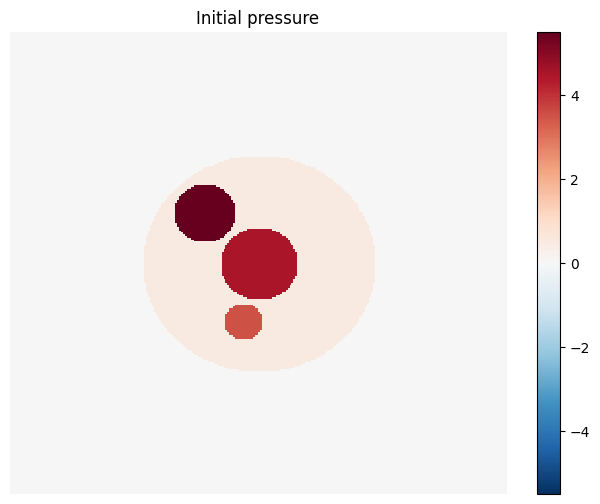

In [3]:
show_field(p0)
plt.title("Initial pressure")

In [4]:
num_sensors = 48
x, y = points_on_circle(num_sensors, 100, (128, 128))
sensors_positions = (x, y)
sensors = Sensors(positions=sensors_positions)

print("Sensors parameters:")
Sensors.__annotations__

Sensors parameters:


{'positions': typing.Tuple[tuple]}

In [5]:
time_axis.t1

2.404163032770157e-05

In [6]:
time_axis.to_array(keep_last=True)[-1]

Array(2.404163e-05, dtype=float32)

In [7]:
@jit
def compiled_simulator(medium, p0):
    return acoustic_solver(medium,
                           time_axis,
                           SemiImplicitEulerCorrected(),
                           p0=p0,
                           sensors=sensors,
                           adjoint=RecursiveCheckpointAdjoint())

In [8]:
sensors_data = compiled_simulator(medium, p0)[..., 0]

/home/antonio/repos/jwave/jwave/acoustics/time_varying.py:290: UserWarning: Both sensors and saveat.fn are set. The latter will be overwritten
  warnings.warn(


Redefining sampling func


In [9]:
%timeit _ = compiled_simulator(medium, p0)[..., 0].block_until_ready()

179 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


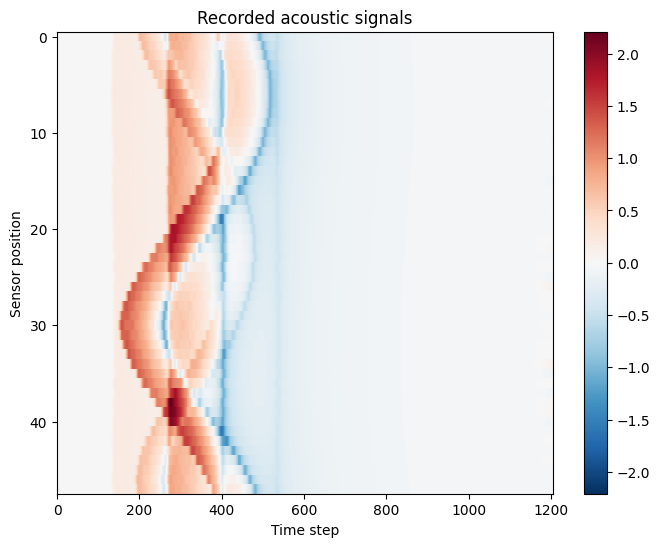

In [10]:
_field = FourierSeries(sensors_data.T, domain)
show_field(_field, "Recorded acoustic signals")
plt.xlabel("Time step")
plt.ylabel("Sensor position")
plt.axis("on")
plt.show()

In this notebooks, we will work on simulated measurements. To make things (a tiny bit) more realistic, we'll add some coloured noise to each sensor trace

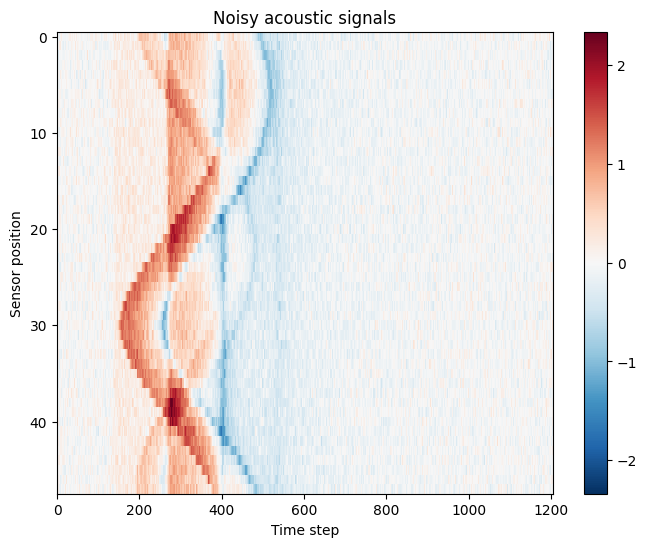

In [11]:
import numpy as np
from jax import grad, random

from jwave.signal_processing import smooth

# Add colored noise
noise = random.normal(random.PRNGKey(42), sensors_data.shape)
for i in range(noise.shape[1]):
    noise = noise.at[:, i].set(smooth(noise[:, i]))

noisy_data = sensors_data + 0.2 * noise

# Show noisy traces
_field = FourierSeries(noisy_data.T, domain)
show_field(_field, "Noisy acoustic signals")
plt.xlabel("Time step")
plt.ylabel("Sensor position")
plt.axis("on")
plt.show()

## Automatic differentiation

In `jwave`, it is possible to take the gradient with respect to any scalar loss, as shown in the following example. The gradients will have the same datatypes as the inputs of to the function, so `Field` gradients will be mapped to `Field` objects.

Here, we write a simple time reversal algorithm using autodiff. Note that time-reversal is proportional to the derivative operator of the `MSE` loss with respect to the measurement data, applied with zero initial conditions.

In [24]:
# The following uses the reciprocity of the wave equation to generate
# a time reversal imaging algorithm
def solver(p0):
    return acoustic_solver(medium,
                           time_axis,
                           SemiImplicitEulerCorrected(),
                           p0=p0,
                           sensors=sensors,
                           adjoint=RecursiveCheckpointAdjoint(),
                           max_steps=1250)

@jit  # Compile the whole algorithm
def lazy_time_reversal(measurements):
    def mse_loss(p0, measurements):
        p0 = p0.replace_params(p0.params)
        p_pred = solver(p0)[..., 0]
        return 0.5 * jnp.sum(jnp.abs(p_pred - measurements) ** 2)

    # Start from an empty field
    p0 = FourierSeries.empty(domain)

    # Take the gradient of the MSE loss w.r.t. the
    # measured data
    p_grad = grad(mse_loss)(p0, measurements)

    return -p_grad

/home/antonio/repos/jwave/jwave/acoustics/time_varying.py:290: UserWarning: Both sensors and saveat.fn are set. The latter will be overwritten
  warnings.warn(


Redefining sampling func


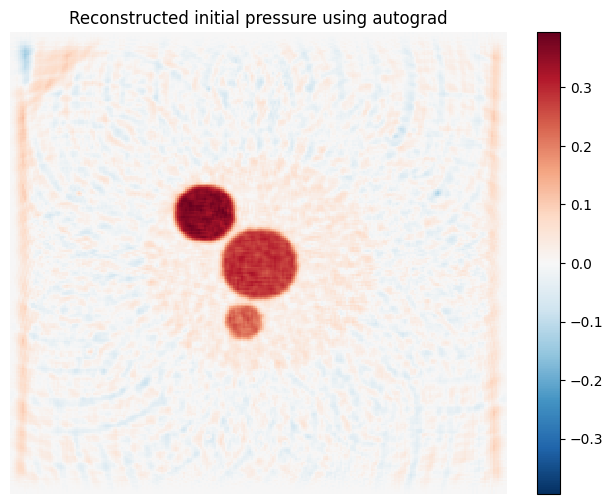

In [25]:
# Reconstruct initial pressure distribution
recon_image = lazy_time_reversal(noisy_data)

# Show reconstructed field
show_field(recon_image, "Reconstructed initial pressure using autograd")

In [26]:
# Timings for the reconstruction algorithm, should be
# ~ 2x the forward function.
%timeit lazy_time_reversal(noisy_data).params.block_until_ready()

1.41 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
